In [1]:
from essentia.standard import *

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import csv

from scipy import interpolate

import IPython.display as ipd

from sklearn.cluster import KMeans

from ipywidgets import Dropdown, Label, FloatSlider, IntSlider, Layout, ToggleButton, ToggleButtons, interactive, VBox, HBox, AppLayout

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [2]:
# interp(x,x_points,y_points) -> y | y = f(x)
def interp(x,x_points,y_points):
    tck = interpolate.splrep(x_points,y_points)
    return interpolate.splev(x, tck)

In [3]:
# segment = segmento do audio a ser reamostrado para 100 pontos
def resample(odf, onsets):
    n = len(onsets)
    new_sample = list()
    
    rate = 100

    for i in range(n-1):
    
        inicio = int(onsets[i])
        fim = int(onsets[i+1])
        step = (fim-inicio)/rate

        yp = odf[inicio:fim]
        xp = np.array(range(inicio,fim))
        #build list to interpolate
        
        xi = np.arange(inicio,fim,step)
        
        #itera nos 100 pontos novos de cada segmento
        new_sample.append(interp(xi, xp, yp))
        
    return new_sample

In [4]:
def min_index(vet):
    l = len(vet)
    index = 0
    min_val = vet[0]
    
    for i in range(l):
        if vet[i] <= min_val:
            min_val = vet[i]
            index = i
    return index

In [5]:
def filtro_picos(odf, largura, min_altura, margem=0):
    
    pico_duplo = 10
    
    tamanho = len(odf)
    onsets = []
    index_min = min_index(odf)
    aux = index_min
    i = margem
    
    while i < tamanho-margem:
        if odf[i] >= min_altura:
            for j in range(largura):
                if odf[i+j] >= odf[aux]:
                    aux = i+j
            onsets.append(aux)
            aux = index_min
            i += largura
        else:
            i += 1
    return onsets

In [6]:
# we start by instantiating the audio loader:
loader = MonoLoader(filename='audios/parixara-2.mp3')

# and then we actually perform the loading:
audio = loader()

len(audio)

3460608

In [7]:
# The OnsetDetection algorithm provides various ODFs.
# we chose Complex-Domain spectral difference function 
od_complex = OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
fft = FFT() # Outputs a complex FFT vector.
c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(np.array(audio), frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.complex', od_complex(magnitude, phase))
#print(pool['odf.complex'])

# 2. Detect onset locations.
onsets = Onsets()

onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])

pool_complex = pool['odf.complex']
plt.figure(dpi=200)
#plt.plot(pool_complex, color='red')

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

In [8]:
# The OnsetDetection algorithm provides various ODFs.
# we chose Complex-Domain spectral difference function 
od_hfc = OnsetDetection(method='hfc')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
fft = FFT() # Outputs a complex FFT vector.
c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(np.array(audio), frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.hfc', od_hfc(magnitude, phase))
#print(pool['odf.complex'])

# 2. Detect onset locations.
onsets = Onsets()

onsets_hfc = onsets(essentia.array([pool['odf.hfc']]), [1])

pool_hfc = pool['odf.hfc']
plt.figure(dpi=200)
#plt.plot(pool_hfc,color='green')

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

In [9]:
# The OnsetDetection algorithm provides various ODFs.
# we chose Complex-Domain spectral difference function 
od_rms = OnsetDetection(method='rms')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
#fft = FFT() # Outputs a complex FFT vector.
#c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(np.array(audio), frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.rms', od_rms(magnitude, phase))
#print(pool['odf.complex'])

# 2. Detect onset locations.
onsets = Onsets()

onsets_rms = onsets(essentia.array([pool['odf.rms']]), [1])

pool_rms = pool['odf.rms']
plt.figure(dpi=200)
#plt.plot(pool_rms,color='blue')

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

In [10]:
rms = RMS()
rms(audio)

0.11982997506856918

In [11]:
# read rhythm onsets (chocalho) marks (in frames)
#with open("par2_rhythm_frames.txt") as file_name:
#    onsets_chocalho = np.loadtxt(file_name, delimiter="\t")

onsets_chocalho = np.array(filtro_picos(pool_hfc, 30, 15000))
#print(onsets_chocalho)

In [12]:
#plt.figure(dpi=1000)
#plt.plot(pool_hfc)

fig = plt.figure()
   
x = np.arange(len(pool_hfc))
y = pool_hfc
   
ax = fig.add_subplot()
ax.plot(x,y)
  
ax.xaxis.set_data_interval(600, 900 ,True)
   
ax.grid() 
     
plt.show()

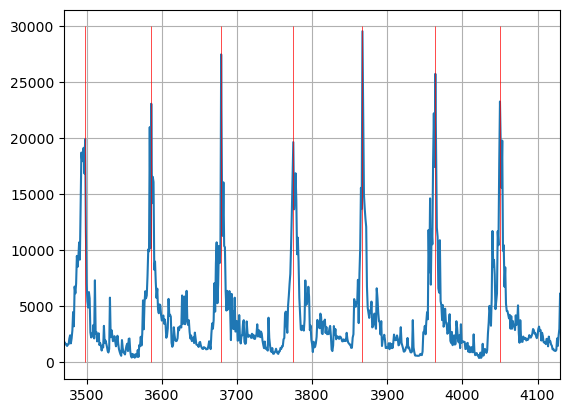

In [13]:
picos = filtro_picos(pool_hfc,30,15000)
#plt.plot(pool_hfc)

fig = plt.figure()
   
x = np.arange(len(pool_hfc))
y = pool_hfc
   
ax = fig.add_subplot()
ax.plot(x,y)

plt.vlines(x = picos, ymin = 0, ymax = 30000, 
           colors = 'red', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 
  
ax.xaxis.set_data_interval(3500, 4100 ,True)
   
ax.grid() 
     
plt.show()

In [14]:
odf_complex = resample(pool_complex,onsets_chocalho)
odf_hfc = resample(pool_hfc,onsets_chocalho)
odf_rms = resample(pool_rms,onsets_chocalho)
#plt.plot(odf_complex[1], color='blue')
#plt.plot(odf_complex[2], color='red')

In [15]:
#PARIXARA 1

comp1 = [1,2,5,6,17,18,21,22,33,34,37,38]
comp2 = [3,4,11,12,19,20,27,28,35,36]
comp3 = [7,8,23,24,39,40]
comp4 = [9,10,13,14,25,26,29,30,41,42]
comp5 = [15,16,31,32,43,44,45,46]

colors = ['blue','orange','green','red','purple','brown','magenta','yellow','cyan','lime','lightcoral','pink','navy','teal']

In [76]:
#PARIXARA 2

comp1 = [1,2,3,4,5,8,9,10,11,12,15,23,24,25,26,27,30,31,32,33,34,37,45,46,47,48,49,52,53,54,55,56,59]
comp2 = [6, 13, 28, 35, 50, 57]
comp3 = [0, 7, 14, 17, 22, 29, 36, 39, 44, 51, 58, 61]
comp4 = [16, 38, 60]
comp5 = [18, 40, 62]
comp6 = [19, 41, 63]
comp7 = [20, 42, 64]
comp8 = [21, 43, 65]

colors = ['blue','orange','green','red','purple','brown','magenta','yellow','cyan','lime','lightcoral','pink','navy','teal','blue','orange','green','red','purple','brown','magenta','yellow','cyan','lime','lightcoral','pink','navy','teal','blue','orange','green','red','purple','brown','magenta','yellow','cyan','lime','lightcoral','pink','navy','teal']
lightcolors = ['gainsboro','lightsalmon','peachpuff','mistyrose','linen','bisque','antiquewhite','navajowhite','cornsilk','beige','honeydew','aquamarine','mintcream','lightcyan','aliceblue','azure','thistle','gainsboro','lightsalmon','peachpuff','mistyrose','linen','bisque','antiquewhite','navajowhite','cornsilk','beige','honeydew','aquamarine','mintcream','lightcyan','aliceblue','azure','thistle']

In [17]:
comp=comp8
l = len(comp)
for i in range(l):
    comp.append(comp[i]+22)
comp

[21, 43, 65, 43, 65, 87]

In [18]:
a = len(audio)
o = len(pool_complex)

k = 65
i = int(onsets_chocalho[k])
f = int(onsets_chocalho[k+1])

i = (a*i)//o
f = (a*f)//o

print(i,f)
ipd.Audio(audio[i:f], rate=44100)


3191335 3255838


In [19]:
#PARIXARA 2 - INTERATIVO

samples = Dropdown(options=np.array(range(0,67)), value=1, description='Num do compasso:')

def plot_complex(n):
    y=np.arange(100)
    plt.figure(dpi=50)
    l=0.2

    plot_cpx = []
    plot_hfc = []
    plot_rms = []

    comp = [n]
    len_comp = len(comp)
    j = 0

    for i in range(len_comp):
        plot_cpx.append(odf_complex[comp[i]])
        plot_hfc.append(odf_hfc[comp[i]])
        plot_rms.append(odf_rms[comp[i]])
        
        #plt.plot(y,plot_cpx[i],color=colors[i], linewidth=l)
        
        #plt.plot(y,plot_hfc[i],color=colors[i], linewidth=l)
        
        #plt.plot(y,plot_rms[i],color=colors[i], linewidth=l)
                
    sample_cpx = []
    sample_hfc = []
    sample_rms = []

    for i in range(len(plot_cpx)):
        sample_cpx.append(plot_cpx[i])
        sample_hfc.append(plot_hfc[i])
        sample_rms.append(plot_rms[i])

    plt.figure(dpi=50)
    plt.plot(y,np.mean(sample_cpx,axis=0),color='red',linewidth=0.7)
    plt.show()
    
    plt.figure(dpi=50)
    plt.plot(y,np.mean(sample_hfc,axis=0),color='green',linewidth=0.7)
    plt.show()

    plt.figure(dpi=50)
    plt.plot(y,np.mean(sample_rms,axis=0),color='blue',linewidth=0.7)
    plt.show()

    
    
w = interactive(plot_complex, n=samples)
w.update()
AppLayout(
    footer=HBox([w.children[0]], layout=Layout(justify_content='center')),
    center=HBox([w.children[1]], layout=Layout(justify_content='center'))
)

AppLayout(children=(HBox(children=(Dropdown(description='Num do compasso:', index=1, options=(0, 1, 2, 3, 4, 5…

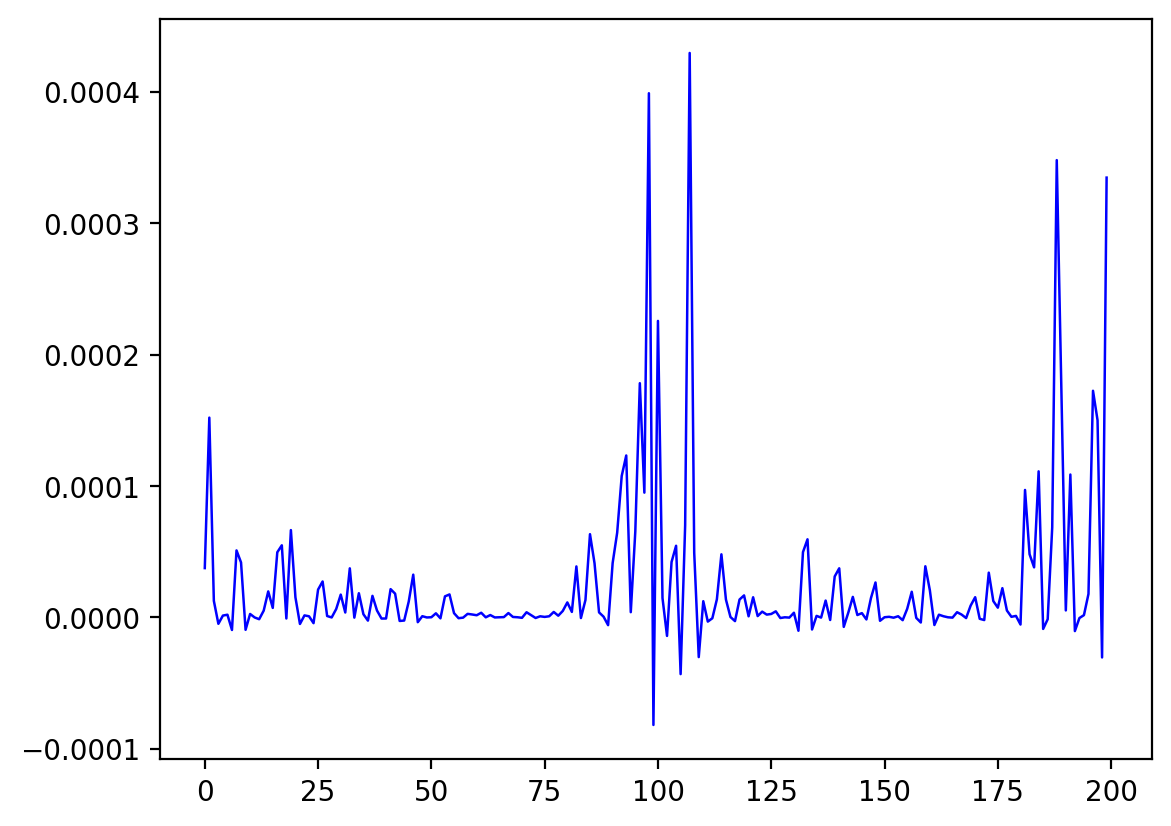

In [20]:
#PARIXARA 1

y=np.arange(200)
plt.figure(dpi=200)
l=0.2

plot = []

comp = comp5
len_comp = len(comp)
j = 0

for i in range(len_comp//2):
    plot.append([])
    plot[i].extend(odf_rms[comp[j]])
    plot[i].extend(odf_rms[comp[j+1]])
    j += 1
    plt.plot(y,plot[i],color=colors[i], linewidth=l)
sample = []
for i in range(len(plot)):
    sample.append(plot[i])
plt.plot(y,np.mean(sample,axis=0),color='blue',linewidth=0.9)

In [21]:
#PARIXARA 2

y=np.arange(100)
plt.figure(dpi=50)
l=0.2

plot = []

comp = comp3
len_comp = len(comp)
j = 0

for i in range(len_comp):
    plot.append(odf_rms[comp[i]])
    plt.plot(y,plot[i],color=colors[i], linewidth=l)
sample = []
for i in range(len(plot)):
    sample.append(plot[i])
plt.plot(y,np.mean(sample,axis=0),color='blue',linewidth=1.2)

In [22]:
sample = []
for i in range(len(plot)):
    sample.append(plot[i])
plt.plot(y,np.mean(sample,axis=0))

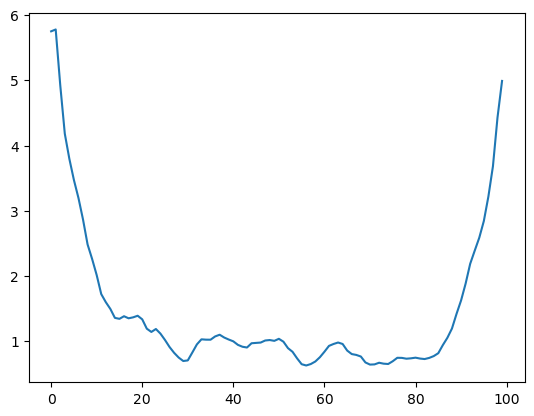

In [23]:
y=np.arange(100)
sample = []
for i in comp1:
    sample.append(odf_complex[i])

#plt.figure(dpi=200)
plt.plot(y,np.mean(sample,axis=0))

- filtragem de picos (selecao de picos) por compasso
   - remover a borda que seria o chocalho (2% talvez)
- da pra usar duracao das notas da partitura como proporcao pra cortar margens
- comparar altura do pico em relacao ao max global ou dentro de uma propria janela (pode ter relacao com duracao das notas dentro da partitura)
   - grande "o suficiente" em relacao a esses 2 criterios
- pra evitar pegar mini-picos vizinhos - definir um epsilon vizinho (pode relacionar com as duracoes da partitura) e pegar o maior de todos

In [24]:
def filtro_picos_compasso(audio, largura, min_altura, margem=0):
    
    pico_duplo = 10
    
    tamanho = len(audio)
    onsets = []
    index_min = min_index(audio)
    aux = index_min
    i = margem
    
    while i < tamanho-margem-largura:
        if audio[i] >= min_altura or i > tamanho-largura-1:
            for j in range(largura):
                if audio[i+j] >= audio[aux]:
                    aux = i+j
            onsets.append([aux+10,audio[aux]])
            aux = index_min
            i += largura
        else:
            i += 1
    return onsets

In [25]:
def seleciona_picos(picos):
    tam = len(picos)
    max_ = picos[0][1]
    min_ = max_
    
    for i in range(tam):
        if picos[i][1] > max_:
            max_ = picos[i][1]
        elif picos[i][1] < min_:
            min_ = picos[i][1]

    media = (min_ + max_)/2
    
    selecionados = []
    for i in range(tam):
        if picos[i][1] >= media:
            selecionados.append(picos[i][0])
    
    return selecionados

In [26]:
def filtro_compasso(odf,altura_min,borda):
    i=0
    tamanho = len(odf)
    picos = []
    while i < tamanho-1:
        j = i
        while j<tamanho-1 and odf[j] > altura_min:
            if odf[j-1] < odf[j] and odf[j+1] < odf[j]:
                picos.append([j+borda,odf[j]])
            j += 1
        if i != j:
            i = j
            if i>=tamanho:
                break
        else:
            i += 1
    
    #return seleciona_picos(picos)
    return picos

In [27]:
compasso = odf_rms[comp[2]]

#vou tirar 5% de cada borda pq a menor nota (semi-colcheia) representa 12.5% do compasso todo
tamanho = len(compasso)
borda = (tamanho*10)//100
compasso_ = compasso[borda:(tamanho-borda)]

max_global = max(compasso_)

f = filtro_compasso(compasso_,0.00002,10)

plt.vlines(x = f, ymin = 0, ymax = 0.0003, 
           colors = 'red', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 
plt.plot(compasso)
print(f)
plt.show()

[[11, 2.7251425811772978e-05], [14, 4.034199998165559e-05], [19, 4.41913217216807e-05], [26, 6.276172369403736e-05], [29, 8.893529808348613e-05], [33, 4.664671607599535e-05], [36, 5.0423622549100705e-05], [39, 0.00011107491478735066], [44, 9.053645086018197e-05], [48, 0.00010241300543318249], [50, 4.778604488823774e-05], [53, 4.206938571921823e-05], [56, 2.967189404017581e-05], [59, 8.465509156712627e-05], [64, 7.654647379260082e-05], [68, 3.063143191000833e-05], [88, 0.00011635525422260456]]


In [28]:
x = np.arange(80)
y = f
compasso = np.array(f,dtype=object)

kmeans = KMeans(n_clusters=3, random_state=0).fit(compasso)
cluster_centers = kmeans.cluster_centers_
cluster_id = kmeans.labels_
print(cluster_centers,cluster_id)

[[2.40000000e+01 5.15074440e-05]
 [7.33333333e+01 7.45110533e-05]
 [4.98571429e+01 7.26009696e-05]] [0 0 0 0 0 0 0 2 2 2 2 2 2 2 1 1 1]


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
def rename_cluster(clusterid):
    tam = len(clusterid)
    new_ids = [0]
    j = 0
    for i in range(1,tam):
        if clusterid[i] == clusterid[i-1]:
            new_ids.append(j)
        else:
            j += 1
            new_ids.append(j)
    return new_ids

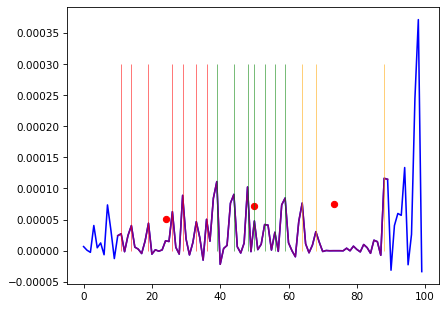

In [30]:
compasso = odf_rms[comp[2]]

fig = plt.figure(dpi=75)
   
    
x1 = np.arange(10,90)
y = compasso_
   
x2 = np.arange(100)
    
ax = fig.add_subplot()
ax.plot(x2,compasso,color='blue')
ax.plot(x1,y,color='purple')

cluster0 = []
cluster1 = []
cluster2 = []

clusters = rename_cluster(cluster_id)

i=0
while i<len(clusters) and clusters[i] == 0:
    cluster0.append(f[i][0])
    i+=1
while i<len(clusters) and clusters[i] == 1:
    cluster1.append(f[i][0])
    i+=1  
while i<len(clusters) and clusters[i] == 2:
    cluster2.append(f[i][0])
    i+=1
    
plt.vlines(x = cluster0, ymin = 0, ymax = 0.0003, 
           colors = 'red', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 

plt.vlines(x = cluster1, ymin = 0, ymax = 0.0003, 
           colors = 'green', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 

plt.vlines(x = cluster2, ymin = 0, ymax = 0.0003, 
           colors = 'orange', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 

plt.scatter(*zip(*cluster_centers),color='red')
  
#ax.xaxis.set_data_interval(3500, 4100 ,True)
     
plt.show()

- checar bordas pra ver se 5% faz sentido
- ouvir os pedacos e visualizar alinhado com o grafico do audio
- clusters de todos os grupos de compasso
  - cluster por compasso e fazer "media" entre tds compassos
- pensar sobre representacao aletrnativa (ver se faz sentido etc)

/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[1.80000000e+01 1.94945521e-04]
 [8.80000000e+01 1.26180459e-04]
 [3.50000000e+01 7.42641617e-05]]
[[5.90000000e+01 1.59392341e-04]
 [2.00000000e+01 1.03344966e-04]
 [8.60000000e+01 4.88889982e-05]]
[[5.57500000e+01 9.23655739e-05]
 [8.13333333e+01 7.59172972e-05]
 [2.30000000e+01 8.57306963e-05]]


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default

[[5.36666667e+01 7.94404186e-05]
 [2.60000000e+01 7.46757304e-05]
 [1.00000000e+01 5.65355556e-05]]
[[2.70000000e+01 1.36971482e-04]
 [5.90000000e+01 4.81899426e-05]
 [3.50000000e+01 7.96248008e-05]]
[[3.53333333e+01 1.16876117e-04]
 [6.20000000e+01 4.37037843e-05]
 [1.73333333e+01 1.01553980e-04]]
[[2.05000000e+01 5.40294591e-05]
 [7.04000000e+01 1.15919294e-04]
 [4.15000000e+01 1.76969769e-04]]
[[7.36666667e+01 1.09068840e-04]
 [1.90000000e+01 1.02287480e-04]
 [4.02000000e+01 1.08819076e-04]]


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default

[[1.35000000e+01 9.60465088e-05]
 [4.60000000e+01 1.27331376e-04]
 [7.65000000e+01 5.59417346e-05]]
[[6.20000000e+01 4.83953412e-05]
 [2.50000000e+01 5.09344417e-05]
 [1.35000000e+01 6.66034496e-05]]
[[6.61666667e+01 6.23842728e-05]
 [3.35000000e+01 9.08425174e-05]
 [1.65000000e+01 8.55889463e-05]]
[[6.35000000e+01 7.46482827e-05]
 [4.02500000e+01 8.10431785e-05]
 [1.50000000e+01 7.82540467e-05]]
[[6.46666667e+01 1.00651020e-04]
 [8.70000000e+01 1.27732539e-04]
 [3.78000000e+01 1.16486892e-04]]


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default

[[8.53333333e+01 8.92739822e-05]
 [5.35000000e+01 8.39801816e-05]
 [1.70000000e+01 1.38029100e-04]]
[[5.70000000e+01 1.22087170e-04]
 [3.10000000e+01 7.22394908e-05]
 [1.10000000e+01 4.58132204e-05]]
[[6.15000000e+01 4.91761446e-05]
 [3.00000000e+01 5.78406148e-05]
 [8.80000000e+01 7.93110929e-05]]
[[7.27500000e+01 6.72414806e-05]
 [3.30000000e+01 7.99442299e-05]
 [1.75000000e+01 1.02002520e-04]]
[[5.85000000e+01 9.75067866e-05]
 [8.30000000e+01 5.82844701e-05]
 [2.58000000e+01 1.06829255e-04]]
[[7.87500000e+01 1.17662458e-04]
 [3.28571429e+01 8.33648185e-05]
 [6.32500000e+01 1.34773948e-04]]


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_7836/880276892.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider usin

[[6.00000000e+01 1.01090806e-04]
 [8.45000000e+01 5.67693019e-05]
 [2.52000000e+01 1.01668397e-04]]
[[5.30000000e+01 6.11835037e-05]
 [1.90000000e+01 6.51686559e-05]
 [8.80000000e+01 1.00540981e-04]]
[[2.96666667e+01 1.00970378e-04]
 [6.30000000e+01 6.02303892e-05]
 [1.67500000e+01 7.76547045e-05]]
[[5.35000000e+01 5.33369688e-05]
 [2.65000000e+01 7.40347874e-05]
 [8.60000000e+01 9.46931676e-05]]
[[6.73333333e+01 1.36417495e-04]
 [2.70000000e+01 1.39479327e-04]
 [4.55000000e+01 1.20985476e-04]]


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[6.30000000e+01 6.64733943e-05]
 [2.67500000e+01 8.58727660e-05]
 [8.60000000e+01 8.39218297e-05]]
[[3.13333333e+01 9.93825021e-05]
 [7.76666667e+01 7.14775157e-05]
 [1.10000000e+01 4.91923280e-05]]


ValueError: n_samples=2 should be >= n_clusters=3.

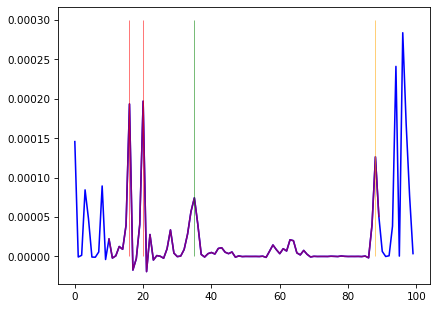

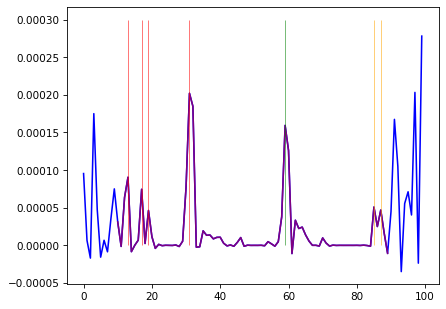

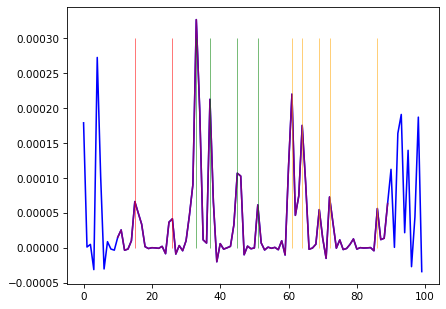

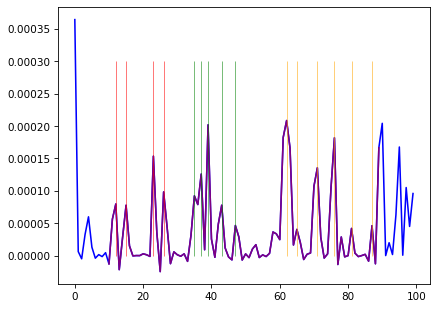

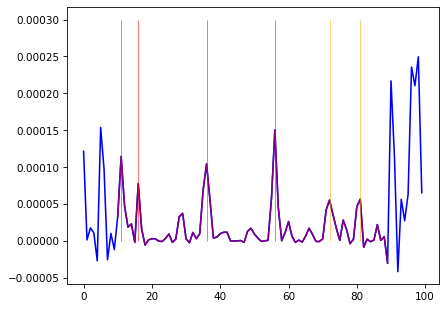

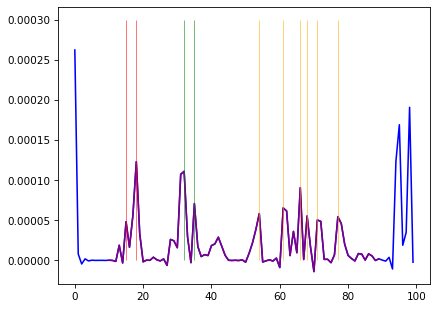

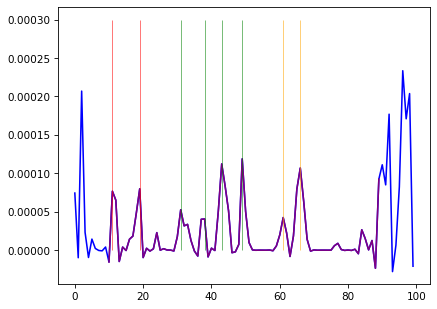

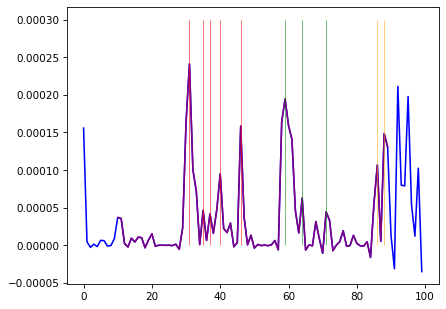

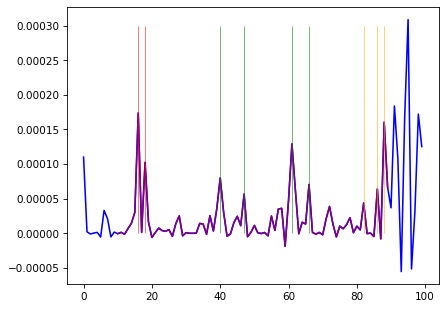

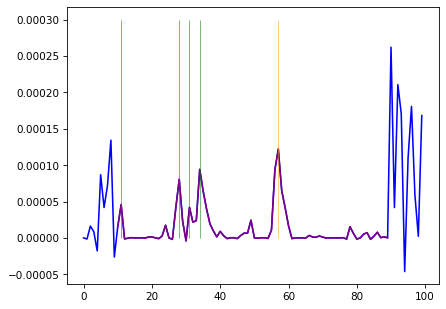

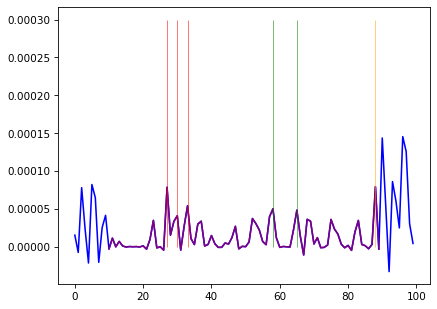

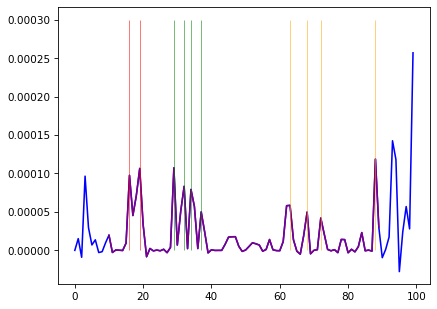

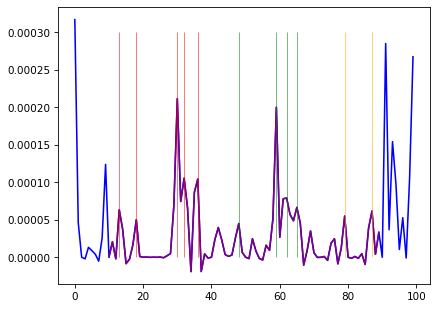

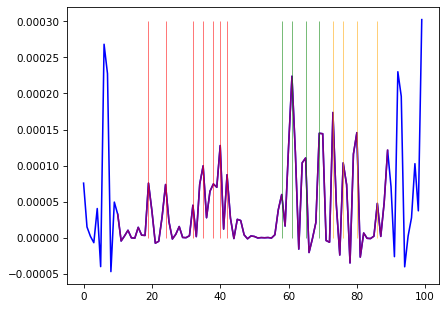

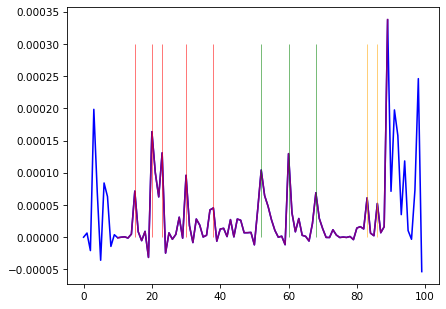

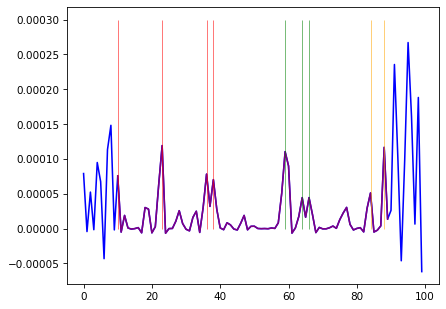

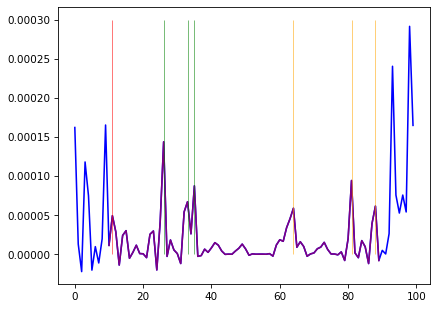

In [161]:
centroids = np.array([[]])
centroids0 =[]
centroids1 =[]
centroids2 =[]
for i in range(len(comp1)):
    compasso = odf_rms[comp1[i]]
    
    tamanho = len(compasso)
    borda = (tamanho*10)//100
    compasso_ = compasso[borda:(tamanho-borda)]

    f = filtro_compasso(compasso_,0.00004,10)
    
    x = np.arange(80)
    y = f
    f = np.array(f,dtype=object)
    
    
    kmeans = KMeans(n_clusters=3, random_state=0).fit(f)
    cluster_centers = kmeans.cluster_centers_
    cluster_id = kmeans.labels_
    
    centroids = np.append(centroids,cluster_centers)
    
    print(cluster_centers)
    
    fig = plt.figure(dpi=75)
   
    
    x1 = np.arange(10,90)
    y = compasso_
   
    x2 = np.arange(100)
    
    ax = fig.add_subplot()
    ax.plot(x2,compasso,color='blue')
    ax.plot(x1,y,color='purple')

    cluster0 = []
    cluster1 = []
    cluster2 = []

    clusters = rename_cluster(cluster_id)

    j=0
    while j<len(clusters) and clusters[j] == 0:
        cluster0.append(f[j][0])
        centroids0.append(f[j])
        j+=1
    while j<len(clusters) and clusters[j] == 1:
        cluster1.append(f[j][0])
        centroids1.append(f[j])
        j+=1  
    while j<len(clusters) and clusters[j] == 2:
        cluster2.append(f[j][0])
        centroids2.append(f[j])
        j+=1
    
    plt.vlines(x = cluster0, ymin = 0, ymax = 0.0003, 
           colors = 'red', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 

    plt.vlines(x = cluster1, ymin = 0, ymax = 0.0003, 
           colors = 'green', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 

    plt.vlines(x = cluster2, ymin = 0, ymax = 0.0003, 
           colors = 'orange', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 
    
    #plt.scatter(*zip(*cluster_centers),color='red')
  
    #ax.xaxis.set_data_interval(3500, 4100 ,True)
     
    #plt.show()
    

    
centroids = centroids.reshape(len(centroids)//2,2)

fig = plt.figure(dpi=75)
ax = fig.add_subplot()
ax.plot(x2,compasso,color='blue')
ax.plot(x1,y,color='purple')   
plt.scatter(*zip(*centroids),color='red')
plt.show()

(-3e-05, 0.0005)

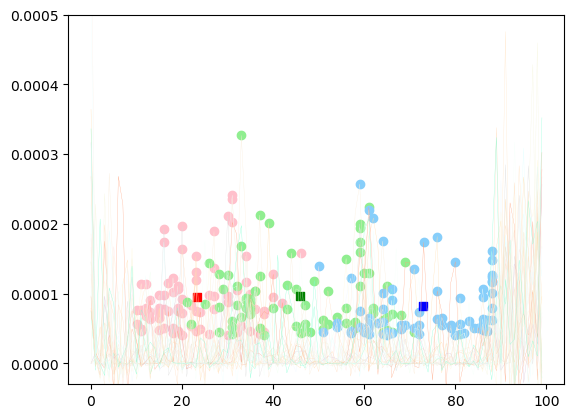

In [138]:
y=np.arange(100)
plt.figure(dpi=100)
l=0.2

plot = []

comp = comp1
len_comp = len(comp)
j = 0

for i in range(len_comp):
    plot.append(odf_rms[comp[i]])
    plt.plot(y,plot[i],color=lightcolors[i], linewidth=l)
sample = []
for i in range(len(plot)):
    sample.append(plot[i])
    
plt.scatter(*zip(*centroids0),color='pink')
plt.scatter(*zip(*centroids1),color='lightgreen')
plt.scatter(*zip(*centroids2),color='lightskyblue')


x0=0
y0=0
for i in range(len(centroids0)):
    x0 += centroids0[i][0]
    y0 += centroids0[i][1]
x0 /=len(centroids0)
y0 /=len(centroids0)
plt.scatter(x0,y0,color='red',marker='s')

x1=0
y1=0
for i in range(len(centroids1)):
    x1 += centroids1[i][0]
    y1 += centroids1[i][1]
x1 /=len(centroids1)
y1 /=len(centroids1)
plt.scatter(x1,y1,color='green',marker='s')

x2=0
y2=0
for i in range(len(centroids2)):
    x2 += centroids2[i][0]
    y2 += centroids2[i][1]
x2 /=len(centroids2)
y2 /=len(centroids2)
plt.scatter(x2,y2,color='blue',marker='s')

plt.ylim([-0.00003,0.0005])

In [139]:
f = np.array
for i in range(len(comp1)):
    compasso = odf_rms[comp1[i]]

    tamanho = len(compasso)
    borda = (tamanho*10)//100
    compasso_ = compasso[borda:(tamanho-borda)]

    f = np.append(f,filtro_compasso(compasso_,0.00004,10))

f = f[1:].reshape(len(f)//2,2)

x = np.arange(80)
y = f
compasso = np.array(f,dtype=object)

kmeans = KMeans(n_clusters=3, random_state=0).fit(compasso)
cluster_centers = kmeans.cluster_centers_
cluster_id = kmeans.labels_
print(cluster_centers,cluster_id)

[[2.58913043e+01 9.55210985e-05]
 [5.82584270e+01 9.37640635e-05]
 [8.09019608e+01 7.81129222e-05]] [0 0 0 2 0 0 0 0 1 2 2 0 0 0 0 1 1 1 1 2 2 2 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0
 1 1 1 0 0 0 0 1 1 1 1 1 2 2 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 0 0 0 1 2 2 0 0
 0 0 1 1 0 0 0 0 1 1 1 1 2 2 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 2 2 2 0 0 0 1 1
 1 2 2 2 0 0 0 0 1 0 0 0 1 1 2 0 0 0 0 0 0 1 1 2 2 0 0 0 0 0 1 1 1 1 2 2 0
 0 0 0 0 0 0 1 1 1 1 2 2 2 2 0 0 0 0 0 1 1 1 2 2 0 0 0 0 1 1 2 0 0 0 0 0 0
 0 1 1 1 1 1 2 0 0 0 0 1 1 2 0 0 0 0 0 1 1 1 1 2 0 0 0 0 1 1 1 2 2 0 0 0 0
 1 2 2 0 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2
 2 0 0 1 0 0 0 1 1 2 0 0 0 0 0 0 1 1 2]


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


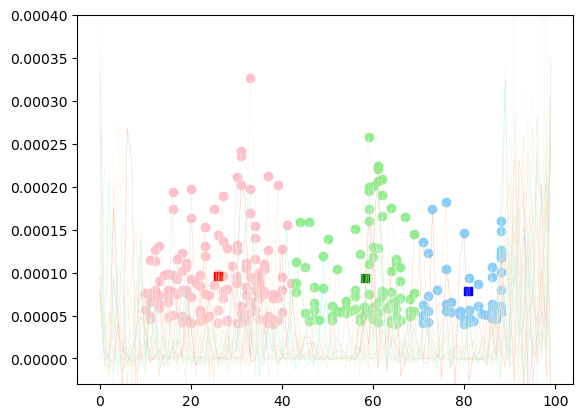

In [140]:
cluster0 = []
cluster1 = []
cluster2 = []


for i in range(len(cluster_id)):
    if cluster_id[i] == 0:
        cluster0.append(f[i])
    elif cluster_id[i] == 1:
        cluster1.append(f[i])
    elif cluster_id[i] == 2:
        cluster2.append(f[i])

y=np.arange(100)
plt.figure(dpi=100)
l=0.2

plot = []

comp = comp3
len_comp = len(comp)
j = 0

for i in range(len_comp):
    plot.append(odf_rms[comp[i]])
    plt.plot(y,plot[i],color=lightcolors[i], linewidth=l)

#plt.vlines(x = cluster0, ymin = 0, ymax = 0.0003, 
#           colors = 'red', 
#           label = 'vline_multiple - full height',
#           linewidth = 0.5) 

#plt.vlines(x = cluster1, ymin = 0, ymax = 0.0003, 
#           colors = 'green', 
#           label = 'vline_multiple - full height',
#           linewidth = 0.5) 

#plt.vlines(x = cluster2, ymin = 0, ymax = 0.0003, 
#           colors = 'orange', 
#           label = 'vline_multiple - full height',
#           linewidth = 0.5) 
    
plt.ylim([-0.00003,0.0004])

plt.scatter(*zip(*cluster0),color='pink')
plt.scatter(*zip(*cluster1),color='lightgreen')
plt.scatter(*zip(*cluster2),color='lightskyblue')

plt.scatter(*cluster_centers[0],color='red',marker='s')
plt.scatter(*cluster_centers[1],color='green',marker='s')
plt.scatter(*cluster_centers[2],color='blue',marker='s')

     
plt.show()

(-3e-05, 0.0004)

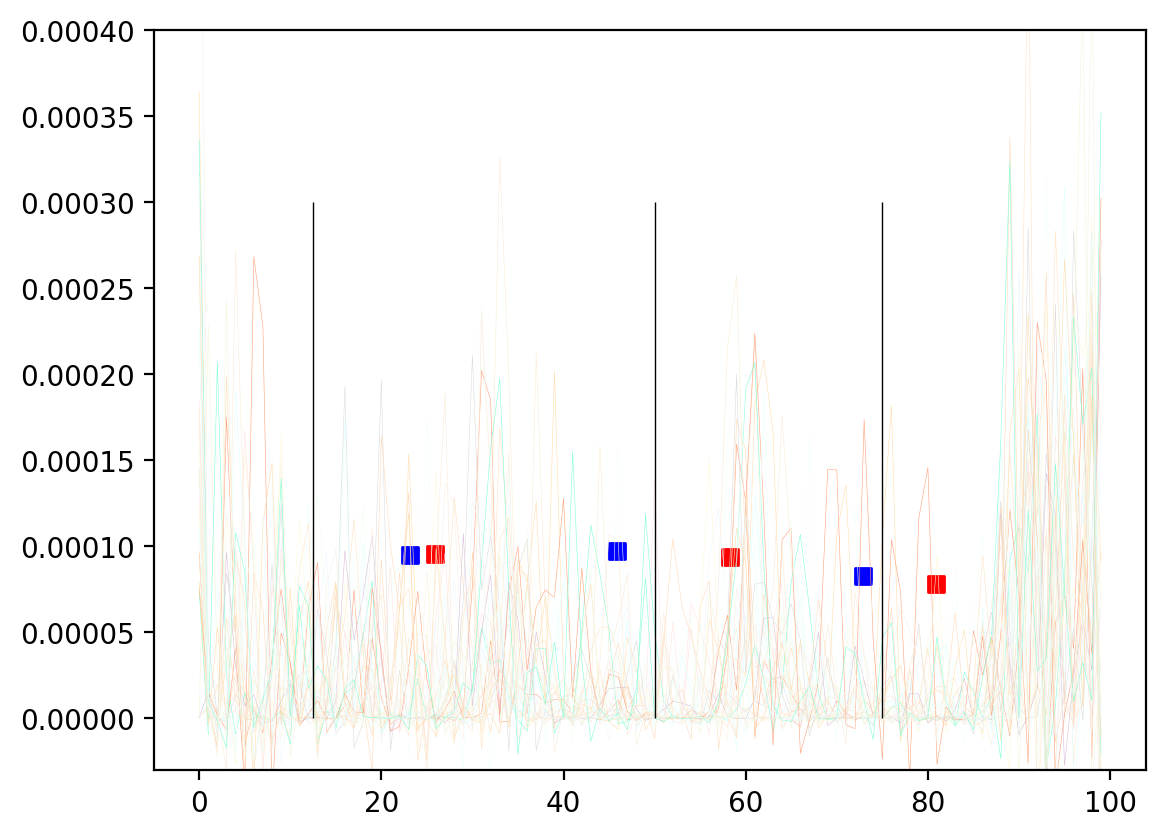

In [141]:
y=np.arange(100)
plt.figure(dpi=200)
l=0.2

plot = []

comp = comp3
len_comp = len(comp)
j = 0

for i in range(len_comp):
    plot.append(odf_rms[comp[i]])
    plt.plot(y,plot[i],color=lightcolors[i], linewidth=l)
    
plt.scatter(*cluster_centers[0],color='red',marker='s')
plt.scatter(*cluster_centers[1],color='red',marker='s')
plt.scatter(*cluster_centers[2],color='red',marker='s')

plt.scatter(x0,y0,color='blue',marker='s')
plt.scatter(x1,y1,color='blue',marker='s')
plt.scatter(x2,y2,color='blue',marker='s')

plt.vlines(x = [0,37.5,75], ymin = 0, ymax = 0.0003, 
           colors = 'black', 
           label = 'vline_multiple - full height',
           linewidth = 0.5) 

plt.ylim([-0.00003,0.0004])

